In [1]:
# https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
# https://drive.google.com/file/d/15Q7DZ7xrJsI2Hji-WbkU9j1mwnODBd5A/view?usp=sharing
# https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [2]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re

from PIL import Image
from io import BytesIO

from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv('./dataset/data.csv')
df.head()

Unnamed: 0                                               Desc  \
0           0  We know that power is shifting: From West to E...   
1           1  Following the success of The Accidental Billio...   
2           2  How to tap the power of social software and ne...   
3           3  William J. Bernstein is an American financial ...   
4           4  Amazing book. And I joined Steve Jobs and many...   

   Unnamed: 0.1                author     genre  \
0           0.0           Moisés Naím  Business   
1           1.0       Blake J. Harris  Business   
2           2.0          Chris Brogan  Business   
3           3.0  William J. Bernstein  Business   
4           4.0           Akio Morita  Business   

                                          image_link  rating  \
0  https://i.gr-assets.com/images/S/compressed.ph...    3.63   
1  https://i.gr-assets.com/images/S/compressed.ph...    3.94   
2  https://i.gr-assets.com/images/S/compressed.ph...    3.78   
3  https://i.gr-assets.com/images/S/compressed.ph...    4.20   
4  https://i.gr-assets.com/images/S/compressed.ph...    4.05   

                                               title  
0  The End of Power: From Boardrooms to Battlefie...  
1  Console Wars: Sega, Nintendo, and the Battle t...  
2  Trust Agents: Using the Web to Build Influence...  
3                      The Four Pillars of Investing  
4                Made in Japan: Akio Morita and Sony

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2382 non-null   int64  
 1   Desc          2382 non-null   object 
 2   Unnamed: 0.1  1185 non-null   float64
 3   author        2382 non-null   object 
 4   genre         2382 non-null   object 
 5   image_link    2382 non-null   object 
 6   rating        2382 non-null   float64
 7   title         2382 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 149.0+ KB


In [5]:
df.describe()

Unnamed: 0  Unnamed: 0.1       rating
count  2382.000000   1185.000000  2382.000000
mean   1226.073887    596.875949     3.995223
std     716.658518    346.103136     0.217733
min       0.000000      0.000000     3.080000
25%     603.250000    296.000000     3.870000
50%    1208.500000    601.000000     4.000000
75%    1854.750000    897.000000     4.140000
max    2450.000000   1193.000000     4.650000

In [6]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [7]:
df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df['cleaned'].apply(make_lower_case)
df['cleaned'] = df['cleaned'].apply(remove_stop_words)
df['cleaned'] = df['cleaned'].apply(remove_punctuation)
df['cleaned'] = df['cleaned'].apply(remove_html)

In [8]:
df.head()

Unnamed: 0                                               Desc  \
0           0  We know that power is shifting: From West to E...   
1           1  Following the success of The Accidental Billio...   
2           2  How to tap the power of social software and ne...   
3           3  William J. Bernstein is an American financial ...   
4           4  Amazing book. And I joined Steve Jobs and many...   

   Unnamed: 0.1                author     genre  \
0           0.0           Moisés Naím  Business   
1           1.0       Blake J. Harris  Business   
2           2.0          Chris Brogan  Business   
3           3.0  William J. Bernstein  Business   
4           4.0           Akio Morita  Business   

                                          image_link  rating  \
0  https://i.gr-assets.com/images/S/compressed.ph...    3.63   
1  https://i.gr-assets.com/images/S/compressed.ph...    3.94   
2  https://i.gr-assets.com/images/S/compressed.ph...    3.78   
3  https://i.gr-assets.com/images/S/compressed.ph...    4.20   
4  https://i.gr-assets.com/images/S/compressed.ph...    4.05   

                                               title  \
0  The End of Power: From Boardrooms to Battlefie...   
1  Console Wars: Sega, Nintendo, and the Battle t...   
2  Trust Agents: Using the Web to Build Influence...   
3                      The Four Pillars of Investing   
4                Made in Japan: Akio Morita and Sony   

                                             cleaned  
0  know power shifting west east north south pres...  
1  following success accidental billionaires mone...  
2  tap power social software networks build busin...  
3  william j bernstein american financial theoris...  
4  amazing book joined steve jobs many akio morit...

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2382 non-null   int64  
 1   Desc          2382 non-null   object 
 2   Unnamed: 0.1  1185 non-null   float64
 3   author        2382 non-null   object 
 4   genre         2382 non-null   object 
 5   image_link    2382 non-null   object 
 6   rating        2382 non-null   float64
 7   title         2382 non-null   object 
 8   cleaned       2382 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 167.6+ KB


In [10]:
df['cleaned'].replace('', np.nan, inplace=True)

In [12]:
df = df[df['cleaned'].notna()]

In [ ]:
df.info()

In [14]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

In [15]:
corpus

[['know',
  'power',
  'shifting',
  'west',
  'east',
  'north',
  'south',
  'presidential',
  'palaces',
  'public',
  'squares',
  'formidable',
  'corporate',
  'behemoths',
  'nimble',
  'startups',
  'and',
  'slowly',
  'surely',
  'men',
  'women',
  'power',
  'merely',
  'shifting',
  'dispersing',
  'also',
  'decaying',
  'power',
  'today',
  'constrained',
  'risk',
  'losing',
  'ever',
  'before',
  'end',
  'power',
  'award',
  'winning',
  'columnist',
  'former',
  'foreign',
  'policy',
  'editor',
  'moiss',
  'nam',
  'illuminates',
  'struggle',
  'once',
  'dominant',
  'megaplayers',
  'new',
  'micropowers',
  'challenging',
  'every',
  'field',
  'human',
  'endeavor',
  'drawing',
  'provocative',
  'original',
  'research',
  'nam',
  'shows',
  'antiestablishment',
  'drive',
  'micropowers',
  'topple',
  'tyrants',
  'dislodge',
  'monopolies',
  'open',
  'remarkable',
  'new',
  'opportunities',
  'also',
  'lead',
  'chaos',
  'paralysis',
  'nam',

In [16]:
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=2, workers=-1)
word2vec_model.build_vocab(corpus)

In [17]:
word2vec_model.wv.vectors_lockf=np.ones(len(word2vec_model.wv), dtype=np.float32)

In [18]:
# gensim 3.x -> Word2Vec.intersect_word2vec_format
# gensim 4.x -> Word2Vec.wv.intersect_word2vec_format
word2vec_model.wv.intersect_word2vec_format('./dataset/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

In [21]:
word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=15)

(0, 0)

In [30]:
# 단어 벡터 평균
def get_doc_vectors(doc_list):
    doc_embedding_list = []
    
    for line in doc_list:
        doc2vec = None
        count = 0
        
        for word in line.split():
            if word in word2vec_model.wv.index_to_key:
                count += 1
                # 문서에 있는 모든 단어들의 벡터를 연산
                if doc2vec is None:
                    # doc2vec = word2vec_model[word]
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        # 단어 벡터를 모두 연산한 벡터의 값을 문서 길이로 나누기
        if doc2vec is not None:
            doc2vec = doc2vec / count
            doc_embedding_list.append(doc2vec)
            
    return doc_embedding_list

In [31]:
doc_embedding_list = get_doc_vectors(df['cleaned'])
print(f"문서 벡터 수: {len(doc_embedding_list)}")

문서 벡터 수: 2381


In [32]:
cosine_similarities = cosine_similarity(doc_embedding_list, doc_embedding_list)
print(cosine_similarities.shape)

(2381, 2381)


In [27]:
def recommendations(title):
    columns = df[['title', 'image_link']]
    
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()
    idx = indices[title]
    
    # 입력한 데이터와 유사한 데이터 추천 
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    
    _indices = [i[0] for i in sim_scores]
    
    recommend = columns.iloc[_indices].reset_index(drop = True)
    
    fig = plt.figure(figsize=(20,30))
    
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

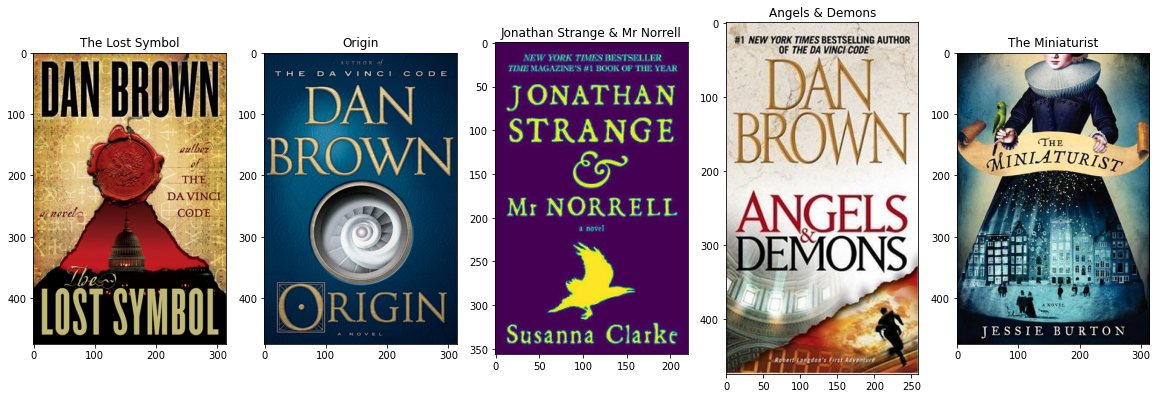

In [28]:
recommendations('The Da Vinci Code')

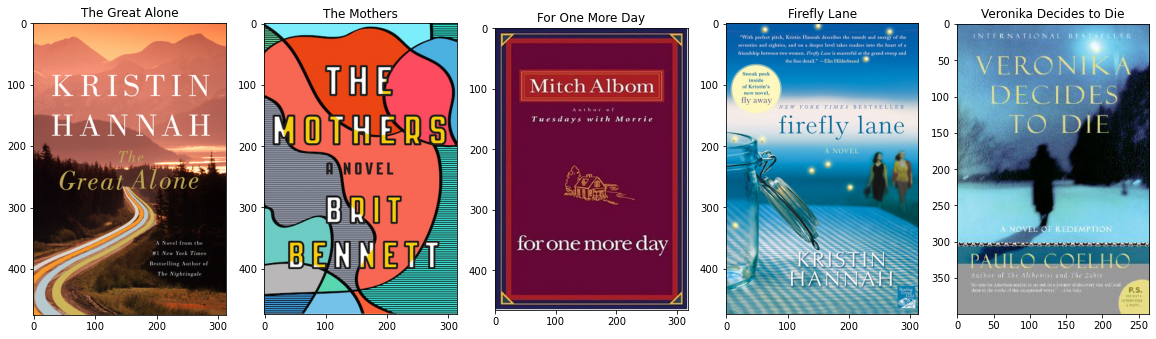

In [29]:
recommendations('The Hunger Games')